# Finding Similar Movies

We'll start by loading up the MovieLens dataset. Using Pandas, we can very quickly load the rows of the u.data and u.item files that we care about, and merge them together so we can work with movie names instead of ID's. (In a real production job, you'd stick with ID's and worry about the names at the display layer to make things more efficient. But this lets us understand what's going on better for now.)

In [1]:
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3), encoding="ISO-8859-1")

m_cols = ['movie_id', 'title']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(2), encoding="ISO-8859-1")

ratings = pd.merge(movies, ratings)


In [2]:
ratings.head()

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3


Now the amazing pivot_table function on a DataFrame will construct a user / movie rating matrix. Note how NaN indicates missing data - movies that specific users didn't rate.

In [4]:
movieRatings = ratings.pivot_table(index=['user_id'],columns=['title'],values='rating')
movieRatings.head(10)

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's extract a Series of users who rated Star Wars:

In [7]:
starWarsRatings = movieRatings['Star Wars (1977)']
starWarsRatings.head(10)

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
5    4.0
6    4.0
7    5.0
8    5.0
9    5.0
Name: Star Wars (1977), dtype: float64

Pandas' corrwith function makes it really easy to compute the pairwise correlation of Star Wars' vector of user rating with every other movie! After that, we'll drop any results that have no data, and construct a new DataFrame of movies and their correlation score (similarity) to Star Wars:

In [6]:
similarMovies = movieRatings.corrwith(starWarsRatings)
similarMovies = similarMovies.dropna()
df = pd.DataFrame(similarMovies)
df.head(10)

C:\Users\Ninja\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ninja\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,0
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398
2 Days in the Valley (1996),0.066654
"20,000 Leagues Under the Sea (1954)",0.289768
2001: A Space Odyssey (1968),0.230884
"39 Steps, The (1935)",0.106453


(That warning is safe to ignore.) Let's sort the results by similarity score, and we should have the movies most similar to Star Wars! Except... we don't. These results make no sense at all! This is why it's important to know your data - clearly we missed something important.

In [8]:
similarMovies.sort_values(ascending=False)

title
Hollow Reed (1996)                                                                   1.000000
Stripes (1981)                                                                       1.000000
Full Speed (1996)                                                                    1.000000
Golden Earrings (1947)                                                               1.000000
Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)    1.000000
Star Wars (1977)                                                                     1.000000
Ed's Next Move (1996)                                                                1.000000
Scarlet Letter, The (1926)                                                           1.000000
Hurricane Streets (1998)                                                             1.000000
Safe Passage (1994)                                                                  1.000000
Outlaw, The (1943)                                    

Our results are probably getting messed up by movies that have only been viewed by a handful of people who also happened to like Star Wars. So we need to get rid of movies that were only watched by a few people that are producing spurious results. Let's construct a new DataFrame that counts up how many ratings exist for each movie, and also the average rating while we're at it - that could also come in handy later.

In [10]:
import numpy as np
movieStats = ratings.groupby('title').agg({'rating': [np.size, np.mean]})
movieStats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

Let's get rid of any movies rated by fewer than 100 people, and check the top-rated ones that are left:

In [11]:
popularMovies = movieStats['rating']['size'] >= 100
movieStats[popularMovies].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                         size      mean
title                                                  
Close Shave, A (1995)                     112  4.491071
Schindler's List (1993)                   298  4.466443
Wrong Trousers, The (1993)                118  4.466102
Casablanca (1942)                         243  4.456790
Shawshank Redemption, The (1994)          283  4.445230
Rear Window (1954)                        209  4.387560
Usual Suspects, The (1995)                267  4.385768
Star Wars (1977)                          584  4.359589
12 Angry Men (1957)                       125  4.344000
Citizen Kane (1941)                       198  4.292929
To Kill a Mockingbird (1962)              219  4.292237
One Flew Over the Cuckoo's Nest (1975)    264  4.291667
Silence of the Lambs, The (1991)          390  4.289744
North by Northwest (1959)                 179  4.284916
Godfather, The (1972)                     413  4.283293

100 might still be too low, but these results look pretty good as far as "well rated movies that people have heard of." Let's join this data with our original set of similar movies to Star Wars:

In [12]:
df = movieStats[popularMovies].join(pd.DataFrame(similarMovies, columns=['similarity']))

C:\Users\Ninja\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [14]:
df.head(10)

,"(rating, size)","(rating, mean)",similarity
title,,,
101 Dalmatians (1996),109,2.908257,0.211132
12 Angry Men (1957),125,4.344000,0.184289
2001: A Space Odyssey (1968),259,3.969112,0.230884
Absolute Power (1997),127,3.370079,0.085440
"Abyss, The (1989)",151,3.589404,0.203709
Ace Ventura: Pet Detective (1994),103,3.048544,0.062689
"Adventures of Priscilla, Queen of the Desert, The (1994)",111,3.594595,0.054740
"African Queen, The (1951)",152,4.184211,0.230540
Air Force One (1997),431,3.631090,0.113164


And, sort these new results by similarity score. That's more like it!

In [15]:
df.sort_values(['similarity'], ascending=False)[:15]

,"(rating, size)","(rating, mean)",similarity
title,,,
Star Wars (1977),584,4.359589,1.000000
"Empire Strikes Back, The (1980)",368,4.206522,0.748353
Return of the Jedi (1983),507,4.007890,0.672556
Raiders of the Lost Ark (1981),420,4.252381,0.536117
Austin Powers: International Man of Mystery (1997),130,3.246154,0.377433
"Sting, The (1973)",241,4.058091,0.367538
Indiana Jones and the Last Crusade (1989),331,3.930514,0.350107
Pinocchio (1940),101,3.673267,0.347868
"Frighteners, The (1996)",115,3.234783,0.332729


Ideally we'd also filter out the movie we started from - of course Star Wars is 100% similar to itself. But otherwise these results aren't bad.

## Activity

100 was an arbitrarily chosen cutoff. Try different values - what effect does it have on the end results?

In [17]:
movieStats2 = ratings.groupby('title').agg({'rating': [np.size, np.mean]})
movieStats2.head(12)

rating          
                                              size      mean
title                                                       
'Til There Was You (1997)                        9  2.333333
1-900 (1994)                                     5  2.600000
101 Dalmatians (1996)                          109  2.908257
12 Angry Men (1957)                            125  4.344000
187 (1997)                                      41  3.024390
2 Days in the Valley (1996)                     93  3.225806
20,000 Leagues Under the Sea (1954)             72  3.500000
2001: A Space Odyssey (1968)                   259  3.969112
3 Ninjas: High Noon At Mega Mountain (1998)      5  1.000000
39 Steps, The (1935)                            59  4.050847
8 1/2 (1963)                                    38  3.815789
8 Heads in a Duffel Bag (1997)                   4  3.250000

In [20]:
%matplotlib inline
import seaborn as sns


In [21]:
movieStats2.columns

MultiIndex(levels=[['rating'], ['size', 'mean']],
           labels=[[0, 0], [0, 1]])

C:\Users\Ninja\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


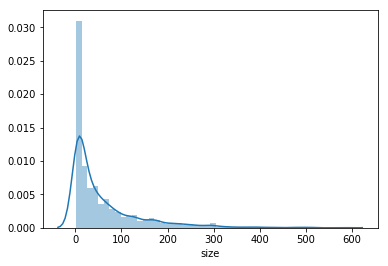

In [22]:
sns.distplot(movieStats2['rating']['size'])

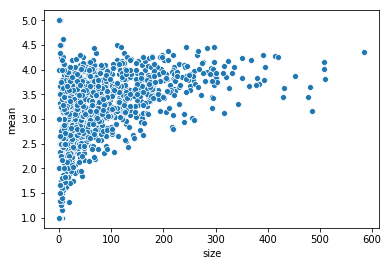

In [27]:
sns.scatterplot(x=movieStats2['rating']['size'], y=movieStats2['rating']['mean'])

C:\Users\Ninja\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


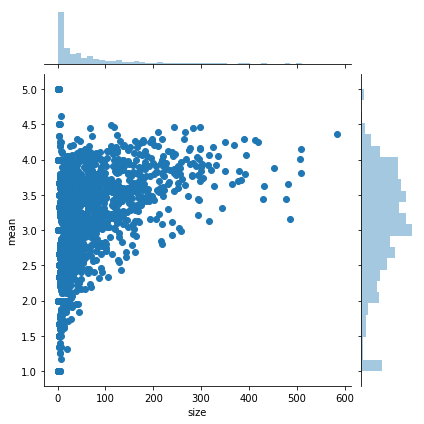

In [28]:
sns.jointplot(x=movieStats2['rating']['size'], y=movieStats2['rating']['mean'])

In [29]:
import numpy as np


In [30]:
z = movieStats2['rating']['size']
z.std()

80.96348193925908

In [31]:
z.median()

27.0

from looking at the data, moving one standard deviation from the mean will be about 107 (87+27) the overall results would be better with higher results. An acceptable minimum would be about 100 as caluculated before